# Day3 Notebook 2: Multi-Agent Patterns

**학습 목표**:
- 여러가지 Multi-Agent 패턴 이해 및 구현
- 패턴별 Use Cases 및 Trade-offs 분석

## Multi-Agent Patterns Overview

본 노트북에서 다룰 패턴들:

| Pattern                  | 핵심 개념                     | Use Case                          |
|--------------------------|-------------------------------|-----------------------------------|
| **Supervisor**           | 중앙 Supervisor가 작업 라우팅 | 고객 상담 티켓 분류               |
| **Plan-Execute**         | 계획 수립 → 단계별 실행       | 복잡한 분석 작업                  |
| **Self-Reflection**      | 생성 → 평가 → 개선 루프       | 코드 리뷰 자동화                  |
| **Hierarchical**         | 다단계 계층 Supervisor        | 대규모 조직 시뮬레이션            |
| **Orchestrator-Worker**  | 작업 분배 → 병렬 실행         | 대량 데이터 처리                  |


In [82]:
import ast
import operator
from dataclasses import dataclass
from pprint import pprint
from typing import Annotated, Literal, TypedDict

from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain.messages import AIMessage, AnyMessage, HumanMessage, SystemMessage
from langchain.tools import ToolRuntime, tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_tavily import TavilySearch
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.runtime import Runtime
from pydantic import BaseModel, Field

load_dotenv()

from openrouter_llm import (
    create_embedding_model,
    create_embedding_model_direct,
    create_openrouter_llm,
)

# LLM 선언
llm = create_openrouter_llm("openai/gpt-4.1-mini")
openai_embeddings = create_embedding_model("openai/text-embedding-3-small")
qwen_embeddings = create_embedding_model_direct("qwen/qwen3-embedding-0.6b")

# 1. Supervisor Pattern 구현

이 섹션에서는 Supervisor 패턴의 StateGraph를 생성하고, 노드/엣지 구성을 완료합니다.

In [10]:
# State 정의
class SupervisorState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    next_agent: str  # Supervisor가 선택한 다음 에이전트 이름

In [38]:
# 1) Tavily 검색 도구 (공식 langchain-tavily 패키지 사용)
# 참고: https://docs.langchain.com/oss/python/integrations/tools/tavily_search
search_tool = TavilySearch(
    max_results=10,
    topic="general",  # news, finance
    include_raw_content="markdown",
    search_depth="advanced",  # basic
)


# 2) 안전한 계산 도구 (AST 기반 화이트리스트)
@tool
def compute(expression: str) -> str:
    """안전 산술 계산기: +, -, *, /, **, 괄호, 실수/정수만 허용.

    Args:
        expression: 계산할 수식 (예: "(12 + 3) * 4**2 / 3")

    Returns:
        계산 결과 문자열

    Examples:
        >>> compute("2 + 2")
        "4"
        >>> compute("(12 + 3) * 4**2 / 3")
        "80.0"
    """
    try:
        # 허용된 연산자만 사용
        operators_map = {
            ast.Add: operator.add,
            ast.Sub: operator.sub,
            ast.Mult: operator.mul,
            ast.Div: operator.truediv,
            ast.Pow: operator.pow,
            ast.USub: operator.neg,
        }

        def eval_expr(node):
            if isinstance(node, ast.Constant):
                return node.value
            elif isinstance(node, ast.BinOp):
                return operators_map[type(node.op)](eval_expr(node.left), eval_expr(node.right))
            elif isinstance(node, ast.UnaryOp):
                return operators_map[type(node.op)](eval_expr(node.operand))
            else:
                raise ValueError(f"지원하지 않는 연산: {type(node)}")

        tree = ast.parse(expression, mode="eval")
        result = eval_expr(tree.body)
        return str(result)

    except Exception as e:
        return f"계산 오류: {str(e)}"


# 검색 에이전트
SEARCH_AGENT = create_agent(
    model=llm,
    tools=[search_tool],
    system_prompt=(
        "[Role]\n"
        "You are a focused web and document search specialist.\n"
        "\n"
        "[Tools]\n"
        "- Use the Tavily search tool to retrieve current, reliable information.\n"
        "\n"
        "[Behavior]\n"
        "- Formulate precise queries and refine them if results are poor.\n"
        "- Aggregate facts from multiple sources. Avoid speculation.\n"
        "\n"
        "[Output Requirements]\n"
        "- Language: Korean.\n"
        "- Provide a concise, well-structured summary.\n"
        "- Always include source URLs inline.\n"
        "- Do not include raw tool output or code fences.\n"
        "\n"
        "[Constraints]\n"
        "- Cite only sources actually retrieved.\n"
        "- If no relevant sources are found, state that briefly.\n"
    ),
)

# 계산 에이전트
CALC_AGENT = create_agent(
    model=llm,
    tools=[compute],
    system_prompt=(
        "[Role]\n"
        "You are a strict calculator.\n"
        "\n"
        "[Tools]\n"
        "- Always call the `compute` tool to evaluate expressions.\n"
        "\n"
        "[Input]\n"
        "- Mathematical expressions with +, -, *, /, **, parentheses, integers/floats.\n"
        "\n"
        "[Output Requirements]\n"
        "- Language: Korean.\n"
        "- Return only the final numeric result as plain text.\n"
        "- No steps, no units unless explicitly requested.\n"
        "\n"
        "[Constraints]\n"
        "- Do not compute manually; always use the tool.\n"
        "- If the expression is invalid, return the tool's error message verbatim.\n"
        "- Do not round unless the user specifies how.\n"
    ),
)

# 번역 에이전트
TRANSLATE_AGENT = create_agent(
    model=llm,
    tools=[],
    system_prompt=(
        "[Role]\n"
        "You are a professional translator.\n"
        "\n"
        "[Behavior]\n"
        "- Preserve meaning, tone, and formatting exactly.\n"
        "- Keep code, placeholders, URLs, and product names unchanged unless clearly translatable.\n"
        "\n"
        "[Input]\n"
        "- A source text and an implied target language from the request.\n"
        "\n"
        "[Output Requirements]\n"
        "- Return only the translated text.\n"
        "- No explanations, no brackets, no code fences.\n"
        "\n"
        "[Constraints]\n"
        "- Maintain lists, headings, and whitespace.\n"
        "- If a term has no clear translation, keep the original or transliterate consistently.\n"
    ),
)


# ============================================================================
# Worker 노드 함수: create_agent 래핑
# ============================================================================


def search_agent(state: SupervisorState) -> dict:
    """검색 전담 에이전트 - 정보 검색, 문서 조회"""
    # create_agent는 LangGraph 기반 CompiledStateGraph를 반환하며,
    # invoke는 messages 키를 가진 dict를 받음 (타입 힌트는 제네릭)
    result = SEARCH_AGENT.invoke({"messages": state["messages"]})  # type: ignore
    last_message = result["messages"][-1]

    return {
        "messages": [AIMessage(content=last_message.content, name="search_agent")],
    }


def calculator_agent(state: SupervisorState) -> dict:
    """계산 전담 에이전트 - 수학 계산, 수식 평가"""
    result = CALC_AGENT.invoke({"messages": state["messages"]})  # type: ignore
    last_message = result["messages"][-1]

    return {
        "messages": [AIMessage(content=last_message.content, name="calculator_agent")],
    }


def translation_agent(state: SupervisorState) -> dict:
    """번역 전담 에이전트 - 언어 번역, 다국어 변환"""
    result = TRANSLATE_AGENT.invoke({"messages": state["messages"]})  # type: ignore
    last_message = result["messages"][-1]

    return {
        "messages": [AIMessage(content=last_message.content, name="translation_agent")],
    }

## Supervisor System Prompt

In [ ]:
# Supervisor System Prompt
SUPERVISOR_SYSTEM_PROMPT = """[Role]
You are the Supervisor of a Multi-Agent system.
Your only job is to read the user's request and ROUTE IT to exactly one specialized agent.

[Available Agents]
1) search — information retrieval (web/document lookup)
   - Use when the user asks to find, look up, search, show sources/documents/URLs/data,
     or "tell me about" a topic.
   - Examples: "Find the official LangGraph docs", "Search how to use Python regex".

2) calculator — arithmetic and expression evaluation
   - Use when the request contains a computable mathematical expression or clearly asks
     for a numeric result.
   - Supported: +, -, *, /, **, parentheses, integers/floats.
   - Examples: "Compute 123 * 456", "What is the sum 1..100?".

3) translation — text translation between languages
   - Use when the user explicitly asks to translate text to another language.
   - Examples: "Translate this to English", "Convert 'Hello World' to Korean".

4) FINISH — end the task without calling an agent
   - Use when none of the above applies, or the input is greeting/small talk,
     or intent is unclear/unsupported.

[Decision Rules]
1) If a valid mathematical expression is present → calculator.
2) If an explicit translation intent exists → translation.
3) If the user requests information retrieval → search.
4) If none of the above rules match unambiguously → FINISH.

[Disambiguation Policy]
- For mixed requests, choose the first task explicitly mentioned.
- If intent is unclear or incomplete, choose FINISH.
- Greetings, chit-chat, or meta questions about the system → FINISH.

[Output Requirements]
- Return JSON only; no prose, no code fences, no backticks, no extra text.
- Exact structure: {"next":"agent_name"}
- Allowed values for agent_name: "search", "calculator", "translation", "FINISH" (exact spelling).
- Do not include any reasoning or comments.

[Valid Example]
{"next":"search"}
"""

In [40]:
class SupervisorOutput(BaseModel):
    next: str = Field(description="다음 에이전트 이름 (search, calculator, translation, FINISH)")


# Supervisor 노드 함수
def supervisor(state: SupervisorState) -> dict:
    """Supervisor: 작업을 분류하여 적절한 Agent에게 라우팅"""
    messages = state["messages"]
    user_query = messages[-1].content if messages else ""

    # LLM을 사용하여 라우팅 결정
    prompt = [
        SystemMessage(content=SUPERVISOR_SYSTEM_PROMPT),
        HumanMessage(content=f"사용자 요청: {user_query}"),
    ]

    try:
        response: SupervisorOutput = llm.with_structured_output(SupervisorOutput).invoke(prompt)
        next_agent = response.next
    except Exception as e:
        print(f"Error in supervisor: {e}")
        next_agent = "FINISH"

    return {
        "messages": [
            AIMessage(
                content=f"[Supervisor] 다음 에이전트로 라우팅: {next_agent}", name="supervisor"
            )
        ],
        "next_agent": next_agent,
    }

In [30]:
# 라우터 함수
def route_to_agent(state: SupervisorState) -> str:
    """Supervisor의 결정에 따라 다음 노드 선택"""
    next_agent = state.get("next_agent", "FINISH")
    return next_agent

In [31]:
def create_supervisor_graph():
    """Supervisor 패턴 그래프 생성"""
    graph = StateGraph(SupervisorState)

    # 노드 추가
    graph.add_node("supervisor", supervisor)
    graph.add_node("search", search_agent)
    graph.add_node("calculator", calculator_agent)
    graph.add_node("translation", translation_agent)

    # Entry point
    graph.set_entry_point("supervisor")

    # Conditional edges: Supervisor -> Workers
    graph.add_conditional_edges(
        "supervisor",
        route_to_agent,
        {
            "search": "search",
            "calculator": "calculator",
            "translation": "translation",
            "FINISH": END,
        },
    )

    # Workers -> END (한 번만 실행 후 종료)
    graph.add_edge("search", END)
    graph.add_edge("calculator", END)
    graph.add_edge("translation", END)

    return graph.compile()

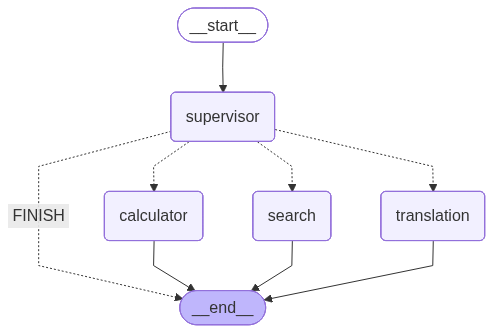

In [32]:
# Supervisor 그래프 생성 및 검증
supervisor_graph = create_supervisor_graph()
supervisor_graph

In [42]:
# Supervisor 패턴 테스트 (4가지 쿼리 타입)
test_queries = [
    "LangGraph 공식 문서에서 Runtime 에 관련된 내용을 찾아서 알려줘.",
    "123 * 456을 계산해줘.",
    "Hello World를 한국어로 번역해줘.",
    "안녕하세요! 오늘 날씨가 좋네요.",
]

for i, query in enumerate(test_queries, 1):
    print(f"\n[테스트 {i}] 질문: {query}")
    result = supervisor_graph.invoke(input={"messages": [HumanMessage(content=query)]})

    # 결과 출력
    messages = result.get("messages", [])
    for msg in messages:
        print(f"  - [{msg.name}] {msg.content}")

    print(f"  -> 최종 라우팅: {result.get('next_agent', 'N/A')}")



[테스트 1] 질문: LangGraph 공식 문서에서 Runtime 에 관련된 내용을 찾아서 알려줘.
  - [None] LangGraph 공식 문서에서 Runtime 에 관련된 내용을 찾아서 알려줘.
  - [supervisor] [Supervisor] 다음 에이전트로 라우팅: search
  - [search_agent] LangGraph 공식 문서에서 Runtime 관련 구체적인 내용을 직접적으로 제공하는 자료를 찾기 어려웠습니다. 현재 확인된 공식 사이트들은 일반적인 정보 소개에 그치고 있어, 명확한 Runtime 설명이나 사용법에 대한 문서는 찾을 수 없었습니다.

더 구체적인 Runtime 관련 정보를 원하시면, LangGraph의 공식 GitHub 저장소나 개발자 커뮤니티, 혹은 공식 문서 내 특정 섹션을 직접 확인하는 것이 필요할 수 있습니다.

참고 사이트:
- https://python.langgraph.com/
- https://chat.langgraph.com/
  -> 최종 라우팅: search

[테스트 2] 질문: 123 * 456을 계산해줘.
  - [None] 123 * 456을 계산해줘.
  - [supervisor] [Supervisor] 다음 에이전트로 라우팅: calculator
  - [calculator_agent] 56088
  -> 최종 라우팅: calculator

[테스트 3] 질문: Hello World를 한국어로 번역해줘.
  - [None] Hello World를 한국어로 번역해줘.
  - [supervisor] [Supervisor] 다음 에이전트로 라우팅: translation
  - [translation_agent] 안녕하세요 세계
  -> 최종 라우팅: translation

[테스트 4] 질문: 안녕하세요! 오늘 날씨가 좋네요.
  - [None] 안녕하세요! 오늘 날씨가 좋네요.
  - [supervisor] [Supervisor] 다음 에이전트로 라우팅: FINISH
  -> 최종 라우팅: 

---

## Pattern 2: Plan-Execute Pattern

### 핵심 개념

Plan-Execute 패턴은 복잡하고 추상적인 작업을 **구체적이고 실행 가능한 단계**로 분해하는 멀티에이전트 설계 원칙입니다. 단순한 순차 실행을 넘어, 다음과 같은 고급 특성을 포함합니다:

1. **문제 분해 (Decomposition)**: 목표를 과업 그래프(Task Graph, 부분순서/의존성)로 분해
2. **전문화된 실행자 (Specialized Executors)**: 코더(Coder), 리서처(Researcher/RAG), 테스트 러너(Test Runner), 린터/포맷터(Linter/Formatter), 보안 스캐너(Security Scanner), 데브옵스(DevOps/CI/CD) 등 도메인별 에이전트 운용
3. **메타인지 (Meta-cognition)**: 시스템이 자신의 능력(가용 도구, 권한, 리소스, 시간/비용 한도)을 파악하고, 불확실성이 높은 단계에서는 인간 승인 요청
4. **재계획 트리거 (Replanning Triggers)**: 사양 모호성, 리소스 부재, 반복 실패, 비용 급등, 보안 경고 등이 발생하면 즉시 재계획
5. **학습 루프 (Learning Loop)**: 실패 원인, 수정 전후 로그, 성능 변화를 메모리에 축적하여 이후 계획 품질 개선

### 아키텍처

```
[User Query] → [Planner] → [Executor] ⟲ (반복)
                    ↓            ↓
                3-5단계 계획   각 단계 실행
                                 ↓
                            [Summary] → [END]
```

#### 프롬프트 사용 팁

1. **Context를 충실히 작성**: AI가 프로젝트를 이해할 수 있도록 충분한 맥락 제공
2. **Goal을 측정 가능하게**: "개선한다" 대신 "30% 향상" 등 구체적 지표 사용
3. **Plan을 함께 검토**: AI가 생성한 계획을 검토하고 개선하여 합의
4. **Execute는 단계별로**: 한 번에 모든 코드를 요청하지 말고, 단계별로 검증하며 진행
5. **Replan Triggers를 명시**: 어떤 상황에서 멈추고 질문해야 하는지 명확히 정의


In [83]:
# Planner: 초기 계획 수립


class PlanExecuteState(TypedDict):
    input: str
    plan: list[str]
    past_steps: list[tuple[str, str]]
    response: str


class Plan(BaseModel):
    steps: list[str] = Field(description="순서대로 실행할 단계들")


planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """주어진 목표에 대해 단계별 계획을 수립하세요.

각 단계는 독립적으로 실행 가능해야 하며, 순서대로 실행 시 최종 답변에 도달해야 합니다.
불필요한 단계는 추가하지 마세요.
마지막 단계의 결과가 최종 답변이 되어야 합니다.
각 단계에 필요한 모든 정보를 포함하세요 - 단계를 건너뛰지 마세요.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner_llm = llm.with_structured_output(Plan)


def plan_step(state: PlanExecuteState) -> dict:
    """초기 계획 수립 노드"""
    user_input = state["input"]
    plan_result = planner_llm.invoke(
        planner_prompt.format(messages=[HumanMessage(content=user_input)])
    )

    return {"plan": plan_result.steps}

In [47]:
# Executor: 현재 단계 실행
def execute_step(state: PlanExecuteState) -> dict:
    """현재 계획의 첫 번째 단계를 실행하는 노드"""
    plan = state["plan"]
    plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))

    task = plan[0]
    task_formatted = f"""다음 계획에 따라 작업 중입니다:
{plan_str}

현재 단계 {1}을 실행하세요: {task}

이전 단계 결과:
{state.get("past_steps", [])}
"""

    result = llm.invoke([HumanMessage(content=task_formatted)])

    return {
        "past_steps": [(task, result.content)],
    }

In [48]:
# Replanner: 계획 업데이트 또는 최종 응답
replanner_prompt = ChatPromptTemplate.from_template("""주어진 목표에 대해 계획을 업데이트하거나 최종 응답을 제공하세요.

원래 목표: {input}

원래 계획:
{plan}

현재까지 완료된 단계:
{past_steps}

계획을 업데이트하세요. 더 이상 필요한 단계가 없고 사용자에게 응답할 수 있다면 Response로 응답하세요.
그렇지 않으면 남은 단계만 포함한 Plan을 작성하세요. 이미 완료된 단계는 계획에 포함하지 마세요.""")

replanner = replanner_prompt | llm.with_structured_output(Act)


def replan_step(state: PlanExecuteState) -> dict:
    """계획 재수립 또는 최종 응답 결정 노드"""
    output = replanner.invoke(
        {
            "input": state["input"],
            "plan": "\n".join(f"{i + 1}. {step}" for i, step in enumerate(state["plan"])),
            "past_steps": "\n".join(
                f"- {step}: {result}" for step, result in state.get("past_steps", [])
            ),
        }
    )

    if isinstance(output.action, Response):
        # 최종 응답
        return {"response": output.action.response}
    else:
        # 계획 업데이트
        return {"plan": output.action.steps}

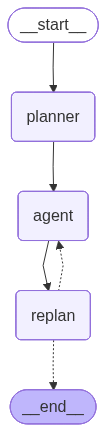

In [51]:
# Plan-Execute 그래프 생성


def should_end(state: PlanExecuteState) -> Literal["agent", END]:
    """작업 완료 여부 판단"""
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"


# 그래프 구성
plan_execute_workflow = StateGraph(PlanExecuteState)

# 노드 추가
plan_execute_workflow.add_node("planner", plan_step)
plan_execute_workflow.add_node("agent", execute_step)
plan_execute_workflow.add_node("replan", replan_step)

# 엣지 정의
plan_execute_workflow.add_edge(START, "planner")
plan_execute_workflow.add_edge("planner", "agent")
plan_execute_workflow.add_edge("agent", "replan")
plan_execute_workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

# 컴파일
plan_execute_graph = plan_execute_workflow.compile()
plan_execute_graph

In [54]:
# Plan-Execute 패턴 테스트
test_input = "간단한 블로그 웹사이트를 개발하려고 합니다. 어떤 단계로 진행해야 하나요?"

result = plan_execute_graph.invoke(
    {
        "input": test_input,
        "plan": [],
        "past_steps": [],
        "response": "",
    }
)

print(f"\n[사용자 질문] {test_input}")
print("\n[최종 계획]")
for i, step in enumerate(result.get("plan", []), 1):
    print(f"  {i}. {step}")

print("\n[완료된 단계]")
for step, result_text in result.get("past_steps", []):
    print(f"  - {step}")
    pprint(f"    결과: {result_text}...")

print("\n[최종 응답]")
print(f"  {result.get('response', 'N/A')}")


[사용자 질문] 간단한 블로그 웹사이트를 개발하려고 합니다. 어떤 단계로 진행해야 하나요?

[최종 계획]
  1. 2. 프론트엔드 개발: React 기반으로 사용자 인터페이스를 구현하며 게시글 목록 보기, 상세 보기, 댓글 작성 기능을 UI에 반영합니다.
  2. 3. 백엔드 개발: Node.js와 Express.js를 사용해 RESTful API를 설계하고 사용자 인증(JWT 기반), 게시글 및 댓글 데이터 관리 기능을 개발합니다.
  3. 4. 데이터베이스 설계 및 구축: MySQL 기반으로 사용자, 게시글, 댓글, 태그 등의 데이터 모델을 설계하고 데이터베이스를 구축합니다.
  4. 5. 통합 및 테스트: 프론트엔드와 백엔드를 연동하여 기능 테스트를 수행하고 버그 수정 및 성능 개선을 진행합니다.
  5. 6. 배포 준비 및 실행: AWS, Vercel, Netlify 또는 Heroku 중 선택해 서버에 코드를 배포하고 도메인 연결, SSL 인증서 설정을 완료합니다.
  6. 7. 운영 및 유지보수: 사용자 피드백을 반영하여 기능 개선, 오류 수정 및 안정적인 서비스 운영을 지속합니다.

[완료된 단계]
  - 2. 프론트엔드 개발: React 기반으로 사용자 인터페이스를 구현하며 게시글 목록 보기, 상세 보기, 댓글 작성 기능을 UI에 반영합니다.
('    결과: 네, 1단계 환경 설정이 완료된 것으로 보고 2단계인 프론트엔드 개발을 시작하겠습니다.\n'
 '\n'
 '---\n'
 '\n'
 '## 2단계: 프론트엔드 개발 - React 기반 UI 구현\n'
 '\n'
 '### 1. 프로젝트 구조 및 주요 라이브러리 설정\n'
 '\n'
 '- React 프로젝트(my-blog-frontend) 생성이 완료되어 있다고 가정합니다.\n'
 '- 주요 라이브러리 설치 (필요 시):\n'
 '  ```bash\n'
 '  cd my-blog-frontend\n'
 '  npm install axios react-router-dom\n'
 '  ```

---

## Pattern 3: Self-Reflection Pattern

### 개념

**Self-Reflection Pattern**은 "생성(Generate) → 평가(Evaluate) → 개선(Refine)" 사이클을  
반복하여 출력 품질을 점진적으로 향상시키는 패턴입니다.

### 아키텍처

```
[User Query] → [Writer] → [Critic] → [Should Revise?]
                   ↓          ↓             ↓
                초안 작성   비평/평가    Yes → Writer (재작성)
                                        No → Finalize → [END]
```

### 핵심 구성 요소

1. **Writer 노드**: 답변 초안 작성 (또는 critique 반영하여 재작성)
2. **Critic 노드**: 초안 평가 → "APPROVE" 또는 "REVISION: [피드백]"
3. **Router**: 재작성 필요 여부 판단 (MAX_ITERATIONS 제한)
4. **Finalize 노드**: 최종 답변 확정

### 장점

- 자동으로 품질 점진적 개선 (self-improving)
- 초안 → 검토 → 수정 흐름이 인간의 작업 방식과 유사
- 외부 피드백 없이도 자체 개선 가능

### 단점

- LLM이 자신의 오류를 항상 감지하지 못할 수 있음 (hallucination)
- 반복 횟수가 많을수록 비용과 시간 증가
- Writer와 Critic이 동일 LLM이면 편향(bias) 발생 가능

### Use Cases

- 코드 리뷰 자동화 (초안 코드 → 버그 검토 → 수정)
- 문서 작성 (기술 문서 초안 → 가독성 검토 → 개선)
- 학술 논문 작성 (Abstract → Peer Review 시뮬레이션 → 재작성)

### 학술적 배경

- [Reflexion: Language Agents with Verbal Reinforcement Learning (Shinn et al., 2023)](https://arxiv.org/abs/2303.11366)
- LLM이 자신의 출력을 비판적으로 평가하고 개선하는 메커니즘

In [84]:
# Self-Reflection State 정의
class ReflectionState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


@dataclass
class ReflectionContext:
    max_iterations: int = 3

In [ ]:
# Generator: 답변 생성 또는 개선
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """당신은 고품질 답변을 작성하는 전문가입니다.

사용자 질문에 대해 명확하고 상세한 답변을 작성하세요.
이전에 비평이 있었다면, 그 비평을 반영하여 답변을 개선하세요.

답변 작성 시 고려사항:
- 정확성: 사실에 기반한 정보 제공
- 완성도: 질문에 대한 완전한 답변
- 명확성: 이해하기 쉬운 표현
- 논리성: 체계적인 구조""",
        ),
        ("placeholder", "{messages}"),
    ]
)


def generation_node(state: ReflectionState, runtime: Runtime[ReflectionContext]) -> dict:
    """답변 생성 노드"""
    response = llm.invoke(generation_prompt.format(messages=state["messages"]))
    return {"messages": [response]}


In [86]:
# Critic: 답변 평가 및 개선점 제시
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """당신은 엄격한 비평가입니다. 제공된 답변을 평가하고 개선점을 제시하세요.

평가 기준:
1. **정확성**: 사실에 기반한 정보인가?
2. **완성도**: 질문에 대한 완전한 답변인가?
3. **명확성**: 이해하기 쉬운 표현인가?
4. **논리성**: 체계적인 구조인가?

각 기준에 대해 구체적인 개선점을 제시하세요.
답변이 충분히 좋다면 "답변이 우수합니다"라고 말하세요.""",
        ),
        ("placeholder", "{messages}"),
    ]
)


def reflection_node(state: ReflectionState, runtime: Runtime[ReflectionContext]) -> dict:
    """비평 노드 - AI/Human 메시지 역할 변환"""
    # 메시지 역할 변환 (Generator의 AI 메시지를 Human으로)
    cls_map = {"ai": HumanMessage, "human": AIMessage}

    # 첫 번째 메시지(사용자 질문)는 유지, 나머지는 역할 변환
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]

    res = llm.invoke(reflection_prompt.format(messages=translated))

    # 비평을 Human 메시지로 반환 (Generator에게 피드백으로 전달)
    return {"messages": [HumanMessage(content=res.content)]}

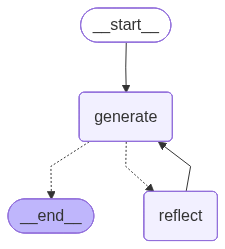

In [87]:
# Self-Reflection 그래프 생성
def should_continue_reflection(
    state: ReflectionState,
    runtime: Runtime[ReflectionContext],
) -> Literal["reflect", END]:
    """반복 횟수 확인"""
    # messages 개수로 반복 횟수 판단 (user + ai + human + ai + ...)
    # MAX_ITERATIONS * 2 = 최대 메시지 수 (각 반복마다 AI + Human)
    context = runtime.context
    if len(state["messages"]) > context.max_iterations * 2:
        return END
    return "reflect"


# 그래프 구성
reflection_builder = StateGraph(
    state_schema=ReflectionState,
    context_schema=ReflectionContext,
)
reflection_builder.add_node("generate", generation_node)
reflection_builder.add_node("reflect", reflection_node)

reflection_builder.add_edge(START, "generate")
reflection_builder.add_conditional_edges("generate", should_continue_reflection)
reflection_builder.add_edge("reflect", "generate")

# 컴파일
reflection_graph = reflection_builder.compile(debug=True)
reflection_graph

In [88]:
# Self-Reflection 패턴 테스트
test_query = "어린 왕자의 현대적 의미에 대한 짧은 에세이를 작성해주세요."

result = reflection_graph.invoke(
    input={"messages": [HumanMessage(content=test_query)]},
    context=ReflectionContext(max_iterations=3),
)

print(f"\n[사용자 질문] {test_query}")
print("\n[반복 과정]")

messages = result.get("messages", [])
for i, msg in enumerate(messages):
    role = (
        "사용자" if msg.type == "human" and i == 0 else "생성기" if msg.type == "ai" else "비평가"
    )

    content_preview = msg.content[:150] + "..." if len(msg.content) > 150 else msg.content
    print(f"\n[{i}] {role}:")
    print(f"  {content_preview}")

print("\n[최종 답변]")
final_answer = messages[-1].content if messages else "N/A"
print(f"  {final_answer[:300]}...")

print("\n[통계]")
print(f"  총 메시지 수: {len(messages)}")
print(f"  반복 횟수: {(len(messages) - 1) // 2}")

[values] {'messages': [HumanMessage(content='어린 왕자의 현대적 의미에 대한 짧은 에세이를 작성해주세요.', additional_kwargs={}, response_metadata={}, id='3c471fc3-6d15-455b-9a0f-3d8a60aaf001')]}
[updates] {'generate': {'messages': [AIMessage(content='어린 왕자는 앙투안 드 생텍쥐페리의 대표작으로, 단순한 동화처럼 보이지만 현대 사회에 깊은 의미를 전달하는 철학적 이야기입니다. 이 작품은 사랑, 우정, 순수함, 그리고 인간 본성에 대한 성찰을 담고 있어 오늘날에도 여전히 유효한 메시지를 전합니다.\n\n현대 사회는 빠른 기술 발전과 물질주의에 집중하며 인간관계와 내면의 가치가 소홀해지기 쉽습니다. 어린 왕자는 그러한 삶의 방식에 경종을 울립니다. 작은 왕자가 지구를 여행하며 만나는 인물들은 현대인의 다양한 단면을 상징하며, 우리는 이들을 통해 자기 중심적이거나 진정한 소통을 잃어버린 모습을 반성하게 됩니다. 특히 ‘본질은 눈에 보이지 않는다’는 어린 왕자의 말은 겉모습이나 외적인 성공에 치우치기 쉬운 현대인에게 내면의 진실과 인간다움에 주목하라는 강력한 메시지입니다.\n\n또한 어린 왕자는 순수함과 상상력의 중요성을 일깨워줍니다. 복잡하고 경쟁이 치열한 현대 사회에서 때로는 어린 시절의 감성과 호기심을 잃고 기계적으로 살아가기도 합니다. 어린 왕자는 삶의 본질을 잊고 살아가는 현대인에게 마음의 눈을 통해 세상을 다시 바라보고, 진정한 관계를 회복하라고 권유합니다.\n\n결론적으로, 어린 왕자는 오늘날에도 우리에게 인간다움, 사랑, 소통의 가치를 잊지 말라고 상기시키는 작품입니다. 물질과 기술 중심의 현대 사회에서 잃어버리기 쉬운 내면의 진실과 순수함을 돌아보게 하는 이 이야기는 시대를 초월한 의미를 지니고 있습니다.', additional_kwargs={'refusal': None}, response_metad

---

## Pattern 4: Orchestrator-Worker Pattern

**개념**: 중앙 Orchestrator가 여러 Worker에게 작업을 균등 분배하고 병렬 실행(Supervisor 와 거의 흡사)

```
[Orchestrator] → [Worker 1]
               → [Worker 2]
               → [Worker 3]
                      ↓
                [Aggregator] → [END]
```

**Use Case**: 대량 데이터 처리, 병렬 API 호출, 배치 작업

In [89]:
# Orchestrator-Worker State 정의


# 커스텀 Dict Merge Reducer
def merge_worker_results(existing: dict[str, str] | None, new: dict[str, str]) -> dict[str, str]:
    """
    여러 Worker의 결과를 안전하게 병합하는 커스텀 reducer

    Args:
        existing: 기존에 누적된 worker_results (None일 수 있음)
        new: 새로 추가될 worker_results

    Returns:
        병합된 Dict (기존 + 새 결과)

    동작 원리:
        - Worker 1: {"worker1": "결과1"}
        - Worker 2: {"worker2": "결과2"}
        - 병합 결과: {"worker1": "결과1", "worker2": "결과2"}
    """
    if existing is None:
        return new
    merged = existing.copy()
    merged.update(new)
    return merged


class OrchestratorState(TypedDict):
    input: str  # 사용자 입력
    tasks: list[str]  # 분배된 작업 리스트
    worker_results: Annotated[dict[str, str], merge_worker_results]
    final_result: str  # 최종 통합 결과

In [90]:
# Orchestrator: 작업 분배
orchestrator_prompt = ChatPromptTemplate.from_template("""
다음 요청을 독립적으로 실행 가능한 3개의 작업으로 분해하세요.
각 작업은 병렬로 실행됩니다.

사용자 요청: {input}

3개의 작업을 JSON 배열로 반환하세요:
{{"tasks": ["작업1", "작업2", "작업3"]}}""")


class TaskList(BaseModel):
    tasks: list[str] = Field(description="병렬 실행할 작업 리스트")


def orchestrator_node(state: OrchestratorState) -> dict:
    """작업 분배 노드"""
    result = llm.with_structured_output(TaskList).invoke(
        orchestrator_prompt.format(input=state["input"])
    )
    return {"tasks": result.tasks}

In [91]:
# Worker 노드들 (3개)
def worker1_node(state: OrchestratorState) -> dict:
    """Worker 1: 첫 번째 작업 실행"""
    if not state.get("tasks") or len(state["tasks"]) < 1:
        return {"worker_results": {"worker1": "작업 없음"}}

    task = state["tasks"][0]
    result = llm.invoke([HumanMessage(content=f"다음 작업을 수행하세요: {task}")])

    return {"worker_results": {"worker1": result.content}}


def worker2_node(state: OrchestratorState) -> dict:
    """Worker 2: 두 번째 작업 실행"""
    if not state.get("tasks") or len(state["tasks"]) < 2:
        return {"worker_results": {"worker2": "작업 없음"}}

    task = state["tasks"][1]
    result = llm.invoke([HumanMessage(content=f"다음 작업을 수행하세요: {task}")])

    return {"worker_results": {"worker2": result.content}}


def worker3_node(state: OrchestratorState) -> dict:
    """Worker 3: 세 번째 작업 실행"""
    if not state.get("tasks") or len(state["tasks"]) < 3:
        return {"worker_results": {"worker3": "작업 없음"}}

    task = state["tasks"][2]
    result = llm.invoke([HumanMessage(content=f"다음 작업을 수행하세요: {task}")])

    return {"worker_results": {"worker3": result.content}}

In [92]:
# Aggregator: 결과 통합
aggregator_prompt = ChatPromptTemplate.from_template("""
다음은 3개 워커의 작업 결과입니다.
이를 통합하여 사용자에게 전달할 최종 답변을 작성하세요.

원래 요청: {input}

---

Worker 1 결과:
{worker1}

Worker 2 결과:
{worker2}

Worker 3 결과:
{worker3}

---

각 Worker의 결과를 통합하여 최종 답변을 작성하세요.""")


def aggregator_node(state: OrchestratorState) -> dict:
    """결과 통합 노드"""
    worker_results = state.get("worker_results", {})

    result = llm.invoke(
        [
            HumanMessage(
                content=aggregator_prompt.format(
                    input=state["input"],
                    worker1=worker_results.get("worker1", "N/A"),
                    worker2=worker_results.get("worker2", "N/A"),
                    worker3=worker_results.get("worker3", "N/A"),
                )
            )
        ]
    )

    return {"final_result": result.content}

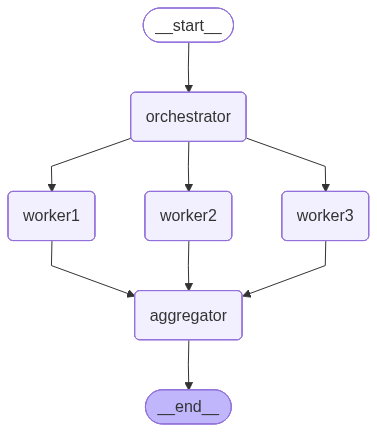

In [93]:
# Orchestrator-Worker 그래프 생성
orchestrator_workflow = StateGraph(OrchestratorState)

# 노드 추가
orchestrator_workflow.add_node("orchestrator", orchestrator_node)
orchestrator_workflow.add_node("worker1", worker1_node)
orchestrator_workflow.add_node("worker2", worker2_node)
orchestrator_workflow.add_node("worker3", worker3_node)
orchestrator_workflow.add_node("aggregator", aggregator_node)

# 엣지 정의 (병렬 실행)
orchestrator_workflow.add_edge(START, "orchestrator")
orchestrator_workflow.add_edge("orchestrator", "worker1")
orchestrator_workflow.add_edge("orchestrator", "worker2")
orchestrator_workflow.add_edge("orchestrator", "worker3")
orchestrator_workflow.add_edge(["worker1", "worker2", "worker3"], "aggregator")
orchestrator_workflow.add_edge("aggregator", END)

# 컴파일
orchestrator_graph = orchestrator_workflow.compile()
orchestrator_graph

In [94]:
# Orchestrator-Worker 패턴 테스트
test_input = "AI, Blockchain, Quantum Computing 세 가지 주제의 최신 동향을 조사해주세요."

result = orchestrator_graph.invoke(
    {
        "input": test_input,
        "tasks": [],
        "worker_results": {},
        "final_result": "",
    }
)

print(f"\n[사용자 요청] {test_input}")
print("\n[분배된 작업]")
for i, task in enumerate(result.get("tasks", []), 1):
    print(f"  {i}. {task}")

print("\n[Worker 결과]")
for worker, result_text in result.get("worker_results", {}).items():
    pprint(f"  [{worker}] {result_text}")

print("\n[최종 통합 결과]")
pprint(f"  {result.get('final_result', 'N/A')}...")


[사용자 요청] AI, Blockchain, Quantum Computing 세 가지 주제의 최신 동향을 조사해주세요.

[분배된 작업]
  1. AI 최신 동향 조사
  2. Blockchain 최신 동향 조사
  3. Quantum Computing 최신 동향 조사

[Worker 결과]
('  [worker1] 알겠습니다. 2024년 상반기 기준으로 AI 최신 동향을 정리해 드리겠습니다.\n'
 '\n'
 '---\n'
 '\n'
 '## 2024년 AI 최신 동향 조사\n'
 '\n'
 '### 1. 멀티모달 AI의 발전\n'
 '- 텍스트, 이미지, 음성, 영상 등 다양한 형태의 데이터를 동시에 이해하고 생성할 수 있는 멀티모달 AI 모델이 크게 발전하고 '
 '있습니다.\n'
 '- 대표적 사례: OpenAI의 GPT-4, Google DeepMind의 Gemini 등 멀티모달 학습을 통해 복합적 문제 해결 능력을 '
 '강화.\n'
 '\n'
 '### 2. 대규모 AI 모델 경량화 및 효율화\n'
 '- 대형 AI 모델의 고성능은 유지하면서 연산량과 에너지 소모를 줄이는 연구가 활발.\n'
 '- 지식 증류(Knowledge Distillation), 프루닝(Pruning), 양자화(Quantization) 기법 등이 적용되어 '
 '모바일 및 임베디드 환경에 AI 적용 확대.\n'
 '\n'
 '### 3. 생성형 AI(Generative AI) 고도화\n'
 '- 텍스트, 이미지, 영상, 음성 등 다양한 콘텐츠 자동 생성 기술이 대중화.\n'
 '- ChatGPT, DALL·E, Stable Diffusion 등 다양한 생성형 AI 도구의 기능이 강화되고 상용화가 확대.\n'
 '\n'
 '### 4. 인공지능 윤리 및 규제 강화\n'
 '- AI의 편향성, 개인정보 보호, 책임소재 등의 이슈가 대두됨에 따라 각국 정부에서 AI 윤리 및 법규 체계 마련 중.\n'
 '- EU AI 법안 등 강력한 가이드라인 도입과 기업 내 윤리 위원회 활성

---

## Pattern 5: Hierarchical Pattern

Hierarchical 패턴은 Supervisor 패턴의 발전 형태로, **다단계 계층 구조**를 가집니다.

**핵심 개념**: Top Supervisor → Team Supervisors → Workers

**구조**:
```
CEO (Chief Supervisor)
├── Tech Team Supervisor
│   ├── Backend Developer
│   └── Frontend Developer
└── Content Team Supervisor
    ├── Writer
    └── Editor
```

In [101]:
# Hierarchical Pattern: State 정의
class HierarchicalState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    current_team: str  # 현재 활성 팀
    team_outputs: dict[str, str]  # 팀별 출력 결과

In [103]:
# Tech Team Workers (하위 계층)
def backend_developer(state: HierarchicalState) -> dict:
    """Backend 개발자: API 및 데이터베이스 설계"""
    messages = state["messages"]
    query = messages[-1].content if messages else ""

    prompt = f"""[Role]
You are a Backend Development Specialist with expertise in server-side architecture, APIs, and databases.

[Task]
Design and specify the backend architecture for the given request.

[Input]
User Request: {query}

[Output Requirements]
Provide a comprehensive backend design that includes:

1. API Architecture
   - RESTful endpoint specifications (HTTP methods, routes, request/response formats)
   - API versioning strategy
   - Rate limiting and throttling approach

2. Database Design
   - Schema design (tables/collections, relationships, indexes)
   - Database technology recommendation (SQL vs NoSQL)
   - Data modeling decisions and rationale

3. Authentication & Authorization
   - Authentication mechanism (JWT, OAuth2, session-based)
   - Authorization strategy (RBAC, ABAC, claims-based)
   - Security best practices

4. Performance & Scalability
   - Caching strategy (Redis, Memcached, CDN)
   - Query optimization approaches
   - Horizontal/vertical scaling considerations
   - Load balancing strategy

5. Technology Stack
   - Framework recommendation (Node.js/Express, Django, FastAPI, etc.)
   - ORM/ODM selection
   - Message queue if needed (RabbitMQ, Kafka)

[Constraints]
- Focus exclusively on backend concerns
- Provide specific technology recommendations with justification
- Consider production-grade requirements (monitoring, logging, error handling)
- Address data consistency and transaction management
- Include API documentation strategy"""

    result = llm.invoke([HumanMessage(content=prompt)])

    return {
        "messages": [AIMessage(content=f"[Backend Dev] {result.content}", name="backend_dev")],
        "team_outputs": {"backend": result.content},
    }


def frontend_developer(state: HierarchicalState) -> dict:
    """Frontend 개발자: UI/UX 설계"""
    messages = state["messages"]
    query = messages[-1].content if messages else ""

    prompt = f"""[Role]
You are a Frontend Development Specialist with expertise in user interfaces, user experience, and modern web frameworks.

[Task]
Design and specify the frontend architecture for the given request.

[Input]
User Request: {query}

[Output Requirements]
Provide a comprehensive frontend design that includes:

1. UI Component Architecture
   - Component hierarchy and structure
   - Reusable component library approach
   - Design system integration

2. User Experience (UX) Flow
   - User journey mapping
   - Navigation structure and routing
   - Interaction patterns and micro-interactions
   - Loading states and error handling UX

3. State Management
   - State management solution (Redux, Zustand, Context API, etc.)
   - Client-side data caching strategy
   - Form validation approach

4. Responsive Design
   - Breakpoint strategy (mobile, tablet, desktop)
   - Mobile-first vs desktop-first approach
   - Cross-browser compatibility considerations

5. Performance Optimization
   - Code splitting and lazy loading strategy
   - Asset optimization (images, fonts, bundles)
   - Rendering optimization (virtual DOM, memoization)
   - Progressive Web App (PWA) considerations

6. Technology Stack
   - Framework recommendation (React, Vue, Angular, Svelte, etc.)
   - Build tool and bundler (Vite, Webpack, etc.)
   - CSS approach (Tailwind, CSS Modules, Styled Components)
   - Testing framework (Jest, Vitest, Playwright)

[Constraints]
- Focus exclusively on frontend concerns
- Provide specific framework and library recommendations with justification
- Consider accessibility (WCAG) standards
- Address SEO requirements if applicable
- Include API integration patterns
- Consider internationalization (i18n) if needed"""

    result = llm.invoke([HumanMessage(content=prompt)])

    return {
        "messages": [AIMessage(content=f"[Frontend Dev] {result.content}", name="frontend_dev")],
        "team_outputs": {"frontend": result.content},
    }

In [105]:
# Content Team Workers (하위 계층)
def writer(state: HierarchicalState) -> dict:
    """Writer: 콘텐츠 작성"""
    messages = state["messages"]
    query = messages[-1].content if messages else ""

    prompt = f"""
You are a Professional Content Writer with expertise in creating engaging, informative, and audience-focused content.

[Task]
Create high-quality written content based on the given request.

[Input]
User Request: {query}

[Output Requirements]
Produce content that includes:

1. Structure & Organization
   - Compelling title/headline
   - Clear introduction with hook
   - Well-organized body with logical flow
   - Strong conclusion with call-to-action (if applicable)
   - Appropriate use of headings and subheadings

2. Audience Considerations
   - Tone appropriate for target audience (professional, casual, technical, etc.)
   - Vocabulary level matched to readers
   - Address reader pain points and interests
   - Provide actionable insights and takeaways

3. SEO Optimization (for web content)
   - Strategic keyword placement (natural, not forced)
   - Meta description suggestion
   - Optimized headings (H1, H2, H3)
   - Internal/external linking opportunities

4. Content Quality
   - Factual accuracy and credibility
   - Original insights and perspectives
   - Supporting examples and evidence
   - Clear, concise language
   - Engaging storytelling elements

5. Format & Style
   - Proper grammar and punctuation
   - Consistent voice and style
   - Appropriate use of lists, quotes, and formatting
   - Scannable content with short paragraphs

[Constraints]
- Focus on creating the initial draft, not editing
- Prioritize clarity and engagement
- Provide value in every paragraph
- Avoid jargon unless appropriate for technical audiences
- Include specific examples where relevant
- Aim for completeness but stay concise"""

    result = llm.invoke([HumanMessage(content=prompt)])

    return {
        "messages": [AIMessage(content=f"[Writer] {result.content}", name="writer")],
        "team_outputs": {"writer": result.content},
    }


def editor(state: HierarchicalState) -> dict:
    """Editor: 콘텐츠 편집 및 검토"""
    # Writer의 출력 찾기
    writer_output = state.get("team_outputs", {}).get("writer", "")

    prompt = f"""
You are a Professional Content Editor with expertise in improving clarity, accuracy, and readability.

[Task]
Review and enhance the content created by the writer, providing specific improvements and editorial feedback.

[Input]
Original Draft:
{writer_output}

[Output Requirements]
Provide a comprehensive editorial review that includes:

1. Grammar & Mechanics
   - Correct spelling, punctuation, and grammar errors
   - Fix sentence structure issues
   - Ensure proper capitalization and formatting
   - Verify consistent tense usage

2. Logical Flow & Structure
   - Assess overall organization and coherence
   - Identify gaps in logic or argumentation
   - Suggest reordering if needed for better flow
   - Ensure smooth transitions between sections

3. Readability & Clarity
   - Simplify complex sentences
   - Remove redundancy and wordiness
   - Clarify ambiguous statements
   - Improve word choice for precision
   - Enhance paragraph breaks for scannability

4. Consistency & Style
   - Verify consistent terminology usage
   - Check tone consistency throughout
   - Ensure formatting consistency (headings, lists, etc.)
   - Align with brand voice and style guidelines

5. Factual Accuracy & Credibility
   - Flag any questionable claims or statistics
   - Suggest adding sources or citations where needed
   - Verify logical soundness of arguments
   - Identify potential misleading statements

6. Editorial Improvements
   - Strengthen weak openings or conclusions
   - Enhance engagement and impact
   - Suggest alternative phrasings for better effect
   - Recommend additions or deletions

[Output Format]
Provide your feedback in two parts:
- Part 1: Summary of key issues found and improvements made
- Part 2: The revised content with all improvements implemented

[Constraints]
- Preserve the writer's core message and intent
- Be constructive and specific in feedback
- Focus on substantive improvements, not just minor tweaks
- Maintain the original structure unless reorganization is clearly needed
- Balance thoroughness with practicality"""

    result = llm.invoke([HumanMessage(content=prompt)])

    return {
        "messages": [AIMessage(content=f"[Editor] {result.content}", name="editor")],
        "team_outputs": {"editor": result.content},
    }

In [107]:
# Tech Team Supervisor (중간 계층)
def tech_team_supervisor(state: HierarchicalState) -> dict:
    """Tech Team을 관리하는 Supervisor"""
    messages = state["messages"]
    user_query = messages[-1].content if messages else ""

    # Backend와 Frontend 결과 수집
    backend_output = state.get("team_outputs", {}).get("backend", "Not yet available")
    frontend_output = state.get("team_outputs", {}).get("frontend", "Not yet available")

    prompt = f"""
You are the Technical Team Supervisor responsible for coordinating backend and frontend development efforts.

[Task]
Review the work completed by backend and frontend developers, then synthesize a comprehensive technical architecture document.

[Input]
Original Request: {user_query}

Backend Developer Output:
{backend_output}

Frontend Developer Output:
{frontend_output}

[Output Requirements]
Provide a unified technical design document that includes:
- System architecture overview
- Integration points between backend and frontend
- API contracts and data flow
- Technology stack summary
- Deployment considerations
- Potential risks and mitigation strategies

[Constraints]
- Ensure backend and frontend designs are compatible
- Identify any gaps or inconsistencies between the two implementations
- Provide concrete technical recommendations
- Focus on scalability and maintainability
- Use clear, professional technical language"""

    result = llm.invoke([HumanMessage(content=prompt)])

    return {
        "messages": [
            AIMessage(content=f"[Tech Supervisor] {result.content}", name="tech_supervisor")
        ],
        "current_team": "tech_team",
    }


# Content Team Supervisor (중간 계층)
def content_team_supervisor(state: HierarchicalState) -> dict:
    """Content Team을 관리하는 Supervisor"""
    # Writer와 Editor의 출력 종합
    writer_output = state.get("team_outputs", {}).get("writer", "Not yet available")
    editor_output = state.get("team_outputs", {}).get("editor", "Not yet available")

    prompt = f"""[Role]
You are the Content Team Supervisor responsible for overseeing content creation and editorial quality.

[Task]
Review the work completed by the writer and editor, then provide final approval with actionable feedback.

[Input]
Writer's Draft:
{writer_output}

Editor's Review:
{editor_output}

---

[Output Requirements]
Provide a comprehensive assessment that includes:
- Quality evaluation (clarity, accuracy, tone, structure)
- Approval status (Approved / Conditional Approval / Needs Revision)
- Specific improvements implemented by the editor
- Any remaining issues or recommendations
- Final remarks for publication readiness

[Constraints]
- Assess both the original content and editorial improvements
- Ensure alignment with brand voice and audience expectations
- Verify factual accuracy and logical flow
- Confirm adherence to style guidelines
- Provide constructive, actionable feedback"""

    result = llm.invoke([HumanMessage(content=prompt)])

    return {
        "messages": [
            AIMessage(content=f"[Content Supervisor] {result.content}", name="content_supervisor")
        ],
        "current_team": "content_team",
    }

In [109]:
# CEO (Chief Supervisor) - 최상위 계층
def ceo_node(state: HierarchicalState) -> dict:
    """CEO: 모든 팀을 조율하는 최상위 Supervisor"""
    messages = state["messages"]
    user_query = messages[0].content if messages else ""

    # 작업 유형 판단
    prompt = f"""[Role]
You are the Chief Executive Officer (CEO) of a multi-team organization.

[Task]
Analyze the incoming request and route it to the appropriate team.

[Available Teams]
1. tech_team - Handle technical architecture, software development, API design, database design, infrastructure
2. content_team - Handle content creation, documentation writing, marketing materials, editorial work
3. both - Projects requiring both technical implementation and content creation

[Routing Decision Criteria]
- Route to tech_team if: Request involves system design, coding, APIs, databases, DevOps, architecture
- Route to content_team if: Request involves writing articles, blog posts, documentation, marketing copy
- Route to both if: Request explicitly needs technical work AND content creation (e.g., "build a system and write documentation")

[Input]
User Request: {user_query}

[Output Requirements]
- Return ONLY valid JSON with no additional text
- Exact format: {{"decision": "team_name"}}
- Valid values for team_name: "tech_team", "content_team", or "both"
- No code fences, no explanations, no extra punctuation

[Decision Rules]
- Default to tech_team if request is ambiguous but mentions technical terms
- Choose content_team only if request is purely about writing/content
- Choose both only if request explicitly requires dual efforts

[Example Outputs]
{{"decision": "tech_team"}}
{{"decision": "content_team"}}
{{"decision": "both"}}"""

    result = llm.invoke([HumanMessage(content=prompt)])

    # JSON 파싱
    try:
        decision = json.loads(result.content)
        team = decision.get("decision", "both")
    except:
        # Fallback
        content_lower = result.content.lower()
        if "tech" in content_lower:
            team = "tech_team"
        elif "content" in content_lower:
            team = "content_team"
        else:
            team = "both"

    return {
        "messages": [AIMessage(content=f"[CEO] Routing to {team} team.", name="ceo")],
        "current_team": team,
    }

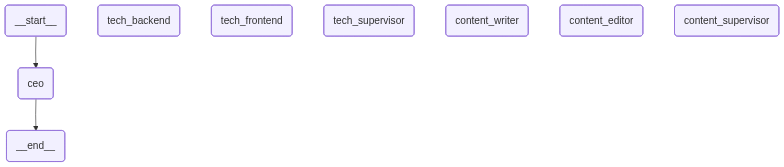

In [110]:
# Hierarchical 그래프 생성 (2단계 계층 구조)
def route_to_team(state: HierarchicalState) -> str:
    """CEO의 결정에 따라 팀으로 라우팅"""
    current_team = state.get("current_team", "tech_team")

    if current_team == "tech_team":
        return "tech_backend"
    elif current_team == "content_team":
        return "content_writer"
    else:
        return "tech_backend"  # Default


# 그래프 구성
hierarchical_builder = StateGraph(HierarchicalState)

# 노드 추가
hierarchical_builder.add_node("ceo", ceo_node)
hierarchical_builder.add_node("tech_backend", backend_developer)
hierarchical_builder.add_node("tech_frontend", frontend_developer)
hierarchical_builder.add_node("tech_supervisor", tech_team_supervisor)
hierarchical_builder.add_node("content_writer", writer)
hierarchical_builder.add_node("content_editor", editor)
hierarchical_builder.add_node("content_supervisor", content_team_supervisor)

# 엣지 정의 (계층 구조)
hierarchical_builder.add_edge(START, "ceo")
hierarchical_builder.add_conditional_edges("ceo", route_to_team)

# Tech Team 흐름
hierarchical_builder.add_edge("tech_backend", "tech_frontend")
hierarchical_builder.add_edge("tech_frontend", "tech_supervisor")
hierarchical_builder.add_edge("tech_supervisor", END)

# Content Team 흐름
hierarchical_builder.add_edge("content_writer", "content_editor")
hierarchical_builder.add_edge("content_editor", "content_supervisor")
hierarchical_builder.add_edge("content_supervisor", END)

# 컴파일
hierarchical_graph = hierarchical_builder.compile()
hierarchical_graph

In [111]:
# Hierarchical Pattern 테스트: 4가지 시나리오

test_cases = [
    {
        "name": "기술팀 전용 - 채팅 API",
        "query": "Design a REST API architecture for a real-time chat application with WebSocket support",
        "expected_team": "tech_team",
        "validation_keywords": ["API", "WebSocket", "endpoint", "database", "authentication"],
        "description": "순수 기술 요청 - 기술팀으로 라우팅되어야 함",
    },
    {
        "name": "콘텐츠팀 전용 - 블로그 포스트",
        "query": "Write a blog post about the benefits of microservices architecture for enterprise applications",
        "expected_team": "content_team",
        "validation_keywords": ["microservices", "benefits", "enterprise", "blog", "article"],
        "description": "순수 콘텐츠 작성 요청 - 콘텐츠팀으로 라우팅되어야 함",
    },
    {
        "name": "기술 중심 - 이커머스 플랫폼",
        "query": "Build an e-commerce platform with product catalog and payment integration",
        "expected_team": "tech_team",
        "validation_keywords": ["API", "database", "payment", "frontend", "backend"],
        "description": "기술 구현 중심 - 기술팀으로 라우팅되어야 함",
    },
    {
        "name": "복합 요청 - SaaS 대시보드",
        "query": "Create a SaaS analytics dashboard with data visualization and publish documentation for end users",
        "expected_team": "tech_team",  # CEO 해석에 따라 "both"도 가능
        "validation_keywords": ["dashboard", "visualization", "analytics", "API", "documentation"],
        "description": "혼합 요청 (기술 + 콘텐츠) - 기술팀 또는 양쪽 팀으로 라우팅 가능",
    },
]

for idx, test in enumerate(test_cases, 1):
    print(f"\n{'=' * 80}")
    print(f"테스트 {idx}/{len(test_cases)}: {test['name']}")
    print("=" * 80)
    print("\n[설명]")
    print(f"  {test['description']}")
    print("\n[요청 쿼리]")
    print(f"  {test['query']}")
    print(f"\n[예상 팀]: {test['expected_team']}")

    # 그래프 실행
    result = hierarchical_graph.invoke(
        {"messages": [HumanMessage(content=test["query"])], "current_team": "", "team_outputs": {}}
    )

    # CEO 라우팅 결정 출력
    actual_team = result.get("current_team", "N/A")
    print("\n[실제 팀 라우팅]")
    print(f"  CEO 결정: {actual_team}")
    routing_match = "✓ 일치" if actual_team == test["expected_team"] else "⚠ 다름 (허용 가능)"
    print(f"  상태: {routing_match}")

    # 팀 작업 결과 표시
    print("\n[팀 작업 결과]")
    team_outputs = result.get("team_outputs", {})
    if team_outputs:
        for team, output in team_outputs.items():
            preview = output[:300] + "..." if len(output) > 300 else output
            print(f"\n  [{team.upper()}]")
            print(f"    {preview}")
    else:
        print("  (캡처된 팀 출력 없음)")

    # 메시지 흐름 표시
    print("\n[메시지 흐름]")
    messages = result.get("messages", [])
    for i, msg in enumerate(messages):
        role = getattr(msg, "name", msg.type) or msg.type
        preview = msg.content[:150] + "..." if len(msg.content) > 150 else msg.content
        print(f"  {i + 1}. [{role}]")
        print(f"     {preview}")

    # 검증: 예상 키워드 확인
    print("\n[키워드 검증]")
    all_content = " ".join([m.content for m in messages])
    found_keywords = [
        kw for kw in test.get("validation_keywords", []) if kw.lower() in all_content.lower()
    ]
    missing_keywords = [
        kw for kw in test.get("validation_keywords", []) if kw.lower() not in all_content.lower()
    ]

    print(f"  예상 키워드: {test.get('validation_keywords', [])}")
    print(f"  발견됨: {found_keywords}")
    if missing_keywords:
        print(f"  누락됨: {missing_keywords}")

    # Pass/Fail 판정 (최소 2개 이상 키워드 존재)
    min_keywords = 2
    validation_pass = len(found_keywords) >= min_keywords
    print("\n[테스트 결과]")
    print(f"  상태: {'✓ 통과' if validation_pass else '✗ 실패'}")
    print(f"  기준: 최소 {min_keywords}/{len(test.get('validation_keywords', []))} 개 키워드 발견")

    print(f"\n{'=' * 80}\n")



테스트 1/4: 기술팀 전용 - 채팅 API

[설명]
  순수 기술 요청 - 기술팀으로 라우팅되어야 함

[요청 쿼리]
  Design a REST API architecture for a real-time chat application with WebSocket support

[예상 팀]: tech_team

[실제 팀 라우팅]
  CEO 결정: tech_team
  상태: ✓ 일치

[팀 작업 결과]

  [FRONTEND]
    Certainly! Below is a comprehensive **frontend architecture design** tailored for the backend routing system described, focusing on a production-ready, scalable, maintainable, and accessible frontend.

---

# 1. UI Component Architecture

### 1.1 Component Hierarchy and Structure

**Top-level contai...

[메시지 흐름]
  1. [human]
     Design a REST API architecture for a real-time chat application with WebSocket support
  2. [ceo]
     [CEO] Routing to tech_team team.
  3. [backend_dev]
     [Backend Dev] Certainly! Here is a comprehensive backend architecture design for the request: **"[CEO] Routing to tech_team team."** This implies a ba...
  4. [frontend_dev]
     [Frontend Dev] Certainly! Below is a comprehensive **frontend architecture desig

---

### 멀티에이전트 아키텍처 도입 시 어떤 패턴을 선택하면 좋을까요?

1. **프로토타입 단계**: Supervisor 의 최대한 단순한 Agent 형태
2. **품질 최우선**: Self-Reflection + Plan-Execute 조합
3. **대량 데이터 처리(데이터 처리 Agent)**: Orchestrator-Worker
4. **다양한 전문 도메인 커버(딥리서치 등)**: Hierarchical

---

## Multi-Agent의 한계 -> RAG 정확도 & Latency 관점

### 문제 정의

1. 아무리 Multi-Agent 시스템을 정교하게 설계해도, `RAG 정확도`는 별개의 문제
2. 많은 단계를 거치면 거칠 수록(Multi Agent Depth), 점점 Latency 가 길어짐

### Multi-Agent vs RAG: 서로 다른 차원의 문제

| 차원 | 해결하는 문제 | 개선 방법 |
|------|-------------|----------|
| **Multi-Agent** | 작업 복잡도, 전문성, 계획 | Supervisor, Hierarchical, Plan-Execute |
| **RAG 정확도** | 문서 검색 정확도, Retrieval 품질 | Hybrid Search, Reranking, Query Decomposition |

핵심 방향성: Multi-Agent는 "어떻게 처리할까?"라는 문제 해결 방향성, RAG는 "정확한 정보를 찾을 수 있나?" 문제 해결

### 해결책: 여러 RAG 기법과 통합

#### 1. Hybrid Search (Keyword + Vector)
```python
# Day2 고급 기법
def hybrid_search(query, collection):
    # BM25 Keyword Search (정확한 용어 매칭)
    keyword_results = bm25_search(query, top_k=10)
    
    # Vector Semantic Search (의미 유사도)
    vector_results = vector_search(query, collection, top_k=10)
    
    # RRF (Reciprocal Rank Fusion) 통합
    return rrf_merge(keyword_results, vector_results)
```

**효과**: 키워드 불일치 문제 해결 (50% → 85% 정확도)

#### 2. Reranking with Cross-Encoder
```python
# Day2 고급 기법
from sentence_transformers import CrossEncoder

reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank_results(query, search_results):
    # 검색 결과 재정렬
    scores = reranker.predict([(query, doc) for doc in search_results])
    return sorted(zip(search_results, scores), key=lambda x: x[1], reverse=True)
```

**효과**: 관련성 낮은 결과 필터링 (Top-1 정확도 60% → 90%)

#### 3. Query Decomposition(Construction)
```python
# Day2 고급 기법
def decompose_query(complex_query):
    # LLM으로 복합 질문 분해
    sub_queries = llm.invoke(f"다음 질문을 단순한 하위 질문들로 분해:\n{complex_query}")
    
    # 각 하위 질문별 검색
    results = []
    for sub_q in sub_queries:
        results.append(search(sub_q))
    
    return merge_results(results)
```

**효과**: 복합 질문 처리 (20% → 70% 성공률)

---

### 결론

1. Multi-Agent ≠ RAG 정확도 개선
   - Multi-Agent: 작업 처리 방식 (라우팅, 협업, 계획)
   - RAG: 정보 검색 품질 (Retrieval 정확도)

2. 실무 해결책:
   - Multi-Agent로 **작업 흐름** 최적화 (Latency vs Quality)
   - 고급 RAG로 **검색 정확도** 최적화 (Hybrid, Reranking, Decomposition)

3. 여러가지 RAG 최적화 기법 필수:
   - Hybrid Search (BM25 + Vector)
   - Reranking (Cross-Encoder)
   - Query Decomposition(Construction)

4. 품질 vs 비용 트레이드오프:
   - Multi-Agent: 비용 2-3배 증가, 품질 향상
   - 고급 RAG: 비용 1.5배 증가, 정확도 30-50%p 향상
   - **조합 시**: 비용 4-5배, 품질 대폭 향상

5. Latency 이슈는 어떻게 해결할 수 있을까요?
   - 오래 걸리는 작업과 짧게 끝나는 작업 분리 
   - UI/UX 적으로 사용자에게 짧게 끝나는 작업 먼저 전달, 오래 걸리는 작업에 대한 안내 표시
   - 모델 변경(-> 프롬프트 고도화) 